In [3]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from bokeh.plotting import markers
from scipy.stats import alpha

%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

In [4]:
from sklearn.pipeline import Pipeline
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, train_test_split, cross_val_score

In [5]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

# from textblob import Word
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xanderquinn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xanderquinn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
train = pd.read_csv("../Datasets/EnglishDatasets/sentiment_data.csv")
test = pd.read_csv("../Datasets/EnglishDatasets/test.csv")

In [7]:
# print(train.head())
print(test.head())

                                                text sentiment
0  Last session of the day  http://twitpic.com/67ezh   neutral
1   Shanghai is also really exciting (precisely -...  positive
2  Recession hit Veronique Branquinho, she has to...  negative
3                                        happy bday!  positive
4             http://twitpic.com/4w75p - I like it!!  positive


In [8]:
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240928 entries, 0 to 241144
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  240928 non-null  int64 
 1   Comment     240928 non-null  object
 2   Sentiment   240928 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.4+ MB


In [9]:
test.dropna(inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3534 non-null   object
 1   sentiment  3534 non-null   object
dtypes: object(2)
memory usage: 55.3+ KB


In [10]:
sentiment_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}
test['sentiment'] = test['sentiment'].map(sentiment_map)

In [11]:
print(test.head())

                                                text  sentiment
0  Last session of the day  http://twitpic.com/67ezh          1
1   Shanghai is also really exciting (precisely -...          2
2  Recession hit Veronique Branquinho, she has to...          0
3                                        happy bday!          2
4             http://twitpic.com/4w75p - I like it!!          2


In [12]:
binary_train = train[train['Sentiment'] != 1]   # 去掉 neutral
binary_train['Sentiment'] = binary_train['Sentiment'].replace({2:1})   # pos=1, neg=0

In [13]:
# binary_train.info()
binary_train.head()

,Unnamed: 0,Comment,Sentiment
1,1,nz retailers don’t even contactless credit car...,0
2,2,forever acknowledge channel help lessons ideas...,1
3,3,whenever go place doesn’t take apple pay doesn...,0
4,4,apple pay convenient secure easy use used kore...,1
6,6,got apple pay south africa it’s widely accepted,1


In [14]:
binary_test = test[test['sentiment'] != 1]
binary_test['sentiment'] = binary_test['sentiment'].replace({2:1})
binary_test.head()

,text,sentiment
1,Shanghai is also really exciting (precisely -...,1
2,"Recession hit Veronique Branquinho, she has to...",0
3,happy bday!,1
4,http://twitpic.com/4w75p - I like it!!,1
5,that`s great!! weee!! visitors!,1


In [15]:
#Clean the datasets
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002700-\U000027BF"  # dingbats
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "]+",
    flags=re.UNICODE
)


def clean_context(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+|\S+\.\S+/\S+', '', text)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'@[^\s]+', ' ', text)
    text = re.sub(r'\[.*?\]', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    # text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'[^\w\s!?]', ' ', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\b\w*\d\w*\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [16]:
binary_train['Comment'] = binary_train['Comment'].apply(lambda x: clean_context(x))

In [17]:
binary_test['text'] = binary_test['text'].apply(lambda x: clean_context(x))

In [18]:
X = binary_train['Comment']
y = binary_train['Sentiment']

x_ex_test = binary_test['text']
y_ex_test = binary_test['sentiment']

train_x, test_x, train_y, test_y = model_selection.train_test_split(X, y, test_size = 0.20, shuffle = True, random_state = 42)

In [19]:
# Naive Bayes
nb_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        lowercase=True,
        token_pattern=r'\b\w+\b',
        ngram_range=(1, 2)
    )),
    ('clf', MultinomialNB())
])

# training
nb_model.fit(train_x, train_y)

# testing
nb_pred = nb_model.predict(test_x)
nb_ex_pred = nb_model.predict(x_ex_test)

print("Naive Bayes Accuracy: ", accuracy_score(nb_pred, test_y))
print("External Dataset Naive Bayes Accuracy: ", accuracy_score(nb_ex_pred, y_ex_test))

Naive Bayes Accuracy:  0.73405836046916
External Dataset Naive Bayes Accuracy:  0.7599809885931559


In [20]:
# Naive Bayes
lr_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        lowercase=True,
        # token_pattern=r'\b\w+\b'
        ngram_range=(1, 2)
    )),
    ('clf', LogisticRegression(max_iter=1000))
])

# training
lr_model.fit(train_x, train_y)

# testing
lr_pred = lr_model.predict(test_x)
lr_ex_pred = lr_model.predict(x_ex_test)

print("LR Accuracy: ", accuracy_score(lr_pred, test_y))
print("External Dataset LR Accuracy: ", accuracy_score(lr_ex_pred, y_ex_test))

LR Accuracy:  0.867598242230723
External Dataset LR Accuracy:  0.8973384030418251


In [21]:
# Naive Bayes
svm_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        lowercase=True,
        token_pattern=r'\b\w+\b',
        ngram_range=(1, 2)
    )),
    ('clf', LinearSVC(max_iter=1000))
])

# training
svm_model.fit(train_x, train_y)

# testing
svm_pred = svm_model.predict(test_x)
svm_ex_pred = svm_model.predict(x_ex_test)

print("SVM Accuracy: ", accuracy_score(svm_pred, test_y))
print("External Dataset SVM Accuracy: ", accuracy_score(svm_ex_pred, y_ex_test))

SVM Accuracy:  0.8859662988840062
External Dataset SVM Accuracy:  0.9344106463878327


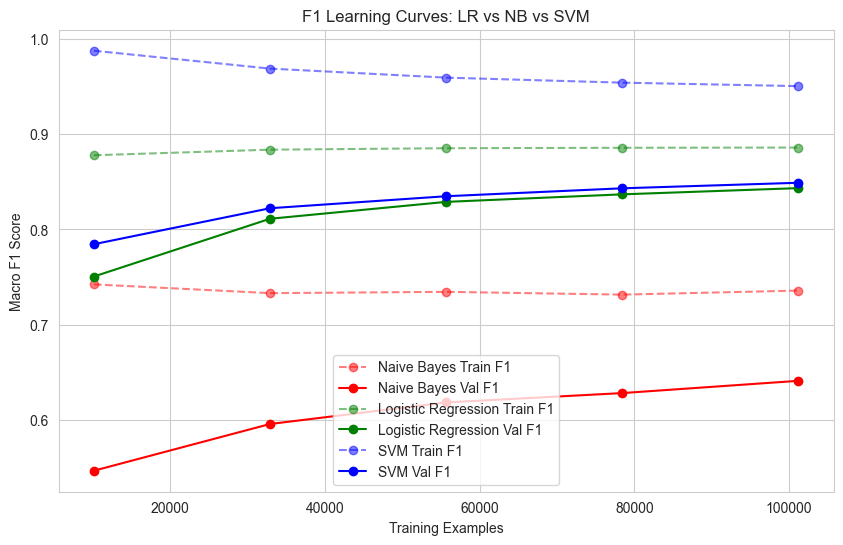

<Figure size 1000x600 with 0 Axes>

In [22]:
# F1 scores curve
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(max_iter=1000)
}
colors = {
    "Naive Bayes": "red",
    "Logistic Regression": "green",
    "SVM": "blue"
}
plt.figure(figsize=(10, 6))
for name, clf in models.items():
    model = Pipeline([
        ('tfidf', TfidfVectorizer(
            stop_words='english',
            lowercase=True,
            token_pattern=r'\b\w+\b',
            ngram_range=(1, 1)
        )),
        ('clf', clf)
    ])

    train_sizes, train_scores, val_scores = learning_curve(
        model, train_x, train_y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    c = colors[name]
    plt.plot(train_sizes, train_mean, '--', marker='o', color=c, alpha=0.5, label=f"{name} Train F1")
    plt.plot(train_sizes, val_mean, '-', marker='o', color=c, label=f"{name} Val F1")

plt.xlabel("Training Examples")
plt.ylabel("Macro F1 Score")
plt.title("F1 Learning Curves: LR vs NB vs SVM")
plt.legend()
plt.grid(True)
# plt.savefig("En_F1_LearningCurves.pdf", bbox_inches='tight')
plt.figure(figsize=(10, 6))
# for name, clf in models.items():
plt.show()

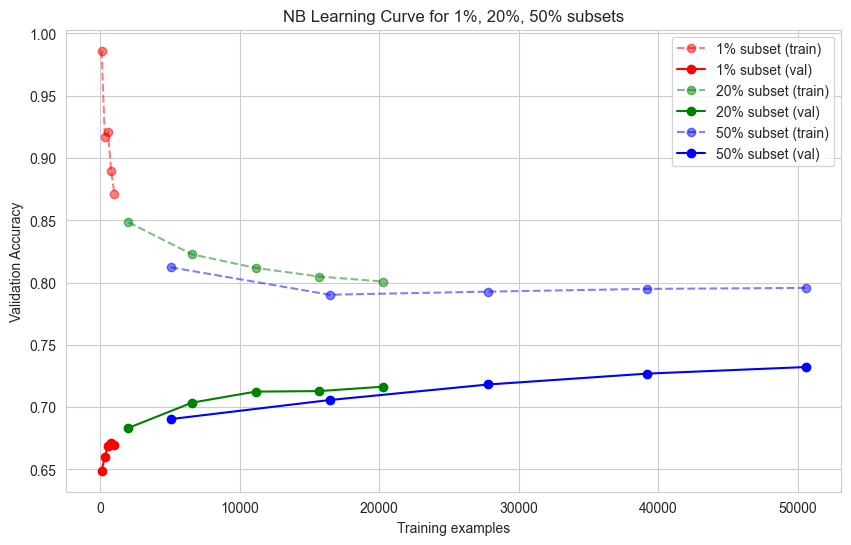

In [30]:
# divide training set to 10%,20%,50%
subset_sizes = [0.01, 0.2, 0.5]
sub_labels = ["1% subset", "20% subset", "50% subset"]
colors = ["red", "green", "blue"]

plt.figure(figsize=(10, 6))

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, _, y_sub, _ = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    nb_model = Pipeline([
        ('tfidf', TfidfVectorizer(
            stop_words='english',
            lowercase=True,
            token_pattern=r'\b\w+\b',
            ngram_range=(1, 1))
        ),
        ('clf', MultinomialNB())
    ])

    # learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        nb_model,
        X_sub, y_sub,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        n_jobs=-1
    )

    # create validation curve
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, '--', marker='o', color=c, alpha=0.5, label=f"{label} (train)")
    plt.plot(train_sizes, val_mean, '-', marker='o', color=c, label=f"{label} (val)")

plt.xlabel("Training examples")
plt.ylabel("Validation Accuracy")
plt.title("NB Learning Curve for 1%, 20%, 50% subsets")
plt.legend()
plt.grid(True)
plt.savefig("En_NB_LearningCurve.pdf", bbox_inches='tight')
plt.show()

In [34]:
subset_sizes = [0.001, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    nb_model = Pipeline([
        ('tfidf', TfidfVectorizer(
            stop_words='english',
            lowercase=True,
            token_pattern=r'\b\w+\b'
            # ngram_range=(1, 1)
        )),
        ('clf', MultinomialNB())
    ])

    nb_model.fit(X_sub, y_sub)
    nb_sub_pred = nb_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("NB Accuracy: ", accuracy_score(nb_sub_pred, y_sub_test))

Subset scale: 0.001
NB Accuracy:  0.652333180372486
Subset scale: 0.2
NB Accuracy:  0.7225932658868163
Subset scale: 0.5
NB Accuracy:  0.734571609231742


In [24]:
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    lr_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    lr_model.fit(X_sub, y_sub)
    lr_sub_pred = lr_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("LR Accuracy: ", accuracy_score(lr_sub_pred, y_sub_test))

Subset scale: 0.1
LR Accuracy:  0.8132223276074051
Subset scale: 0.2
LR Accuracy:  0.840301928548846
Subset scale: 0.5
LR Accuracy:  0.8635946885867847


In [31]:
subset_sizes = [0.01, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    svm_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LinearSVC(max_iter=1000))
    ])

    svm_model.fit(X_sub, y_sub)
    svm_sub_pred = svm_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("SVM Accuracy: ", accuracy_score(svm_sub_pred, y_sub_test))


Subset scale: 0.01
SVM Accuracy:  0.7428525807353
Subset scale: 0.2
SVM Accuracy:  0.8487887290546949
Subset scale: 0.5
SVM Accuracy:  0.8696016440088523
